In [ ]:
import tensorflow as tf
import warnings
# Suppress TensorFlow deprecation warnings
tf.get_logger().setLevel('ERROR')
# Suppress general Python warnings (optional but helpful)
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report


# === IMAGE PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 12

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from tensorflow.python.client import device_lib

print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices("GPU"))
print("\nDevice List:")
print(device_lib.list_local_devices())


TensorFlow version: 2.15.0
Available GPUs: []

Device List:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14442485823094023015
xla_global_id: -1
]


In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# === SET PATH ===
dataset_path = "./data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
output_dir = "./split_dataset"
os.makedirs(output_dir, exist_ok=True)

# === CREATING TRAIN, VALIDATION, TEST SPLIT ===
all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_name)

df = pd.DataFrame({"image": all_images, "label": all_labels})

# Split dataset: 70% Train, 15% Val, 15% Test
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [4]:
print("Unique labels:", df["label"].unique())

Unique labels: ['Cyst' 'Normal' 'Stone' 'Tumor']


In [5]:
# === IMAGE DATA GENERATORS WITH AUGMENTATION ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 specific preprocessing
    rotation_range=20,        # Random rotation (0-20 degrees)
    width_shift_range=0.2,    # Random width shift (20% of width)
    height_shift_range=0.2,   # Random height shift (20% of height)
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True      # Random horizontal flip
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # No augmentation for val/test

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # Important for evaluation
)

Found 7467 validated image filenames belonging to 4 classes.
Found 2489 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


In [6]:
def show_images(path,title,cmap=None):
    labels = list(os.listdir(path))
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    random_indices = random.sample(range(1, 101), 10)

    for i, idx in enumerate(random_indices, 1):
        file_path = os.path.join(path, labels[idx])
        image = Image.open(file_path)
        subplot_row = (i - 1) // 5
        subplot_col = (i - 1) % 5
        axes[subplot_row, subplot_col].imshow(image, cmap=cmap)
        axes[subplot_row, subplot_col].axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

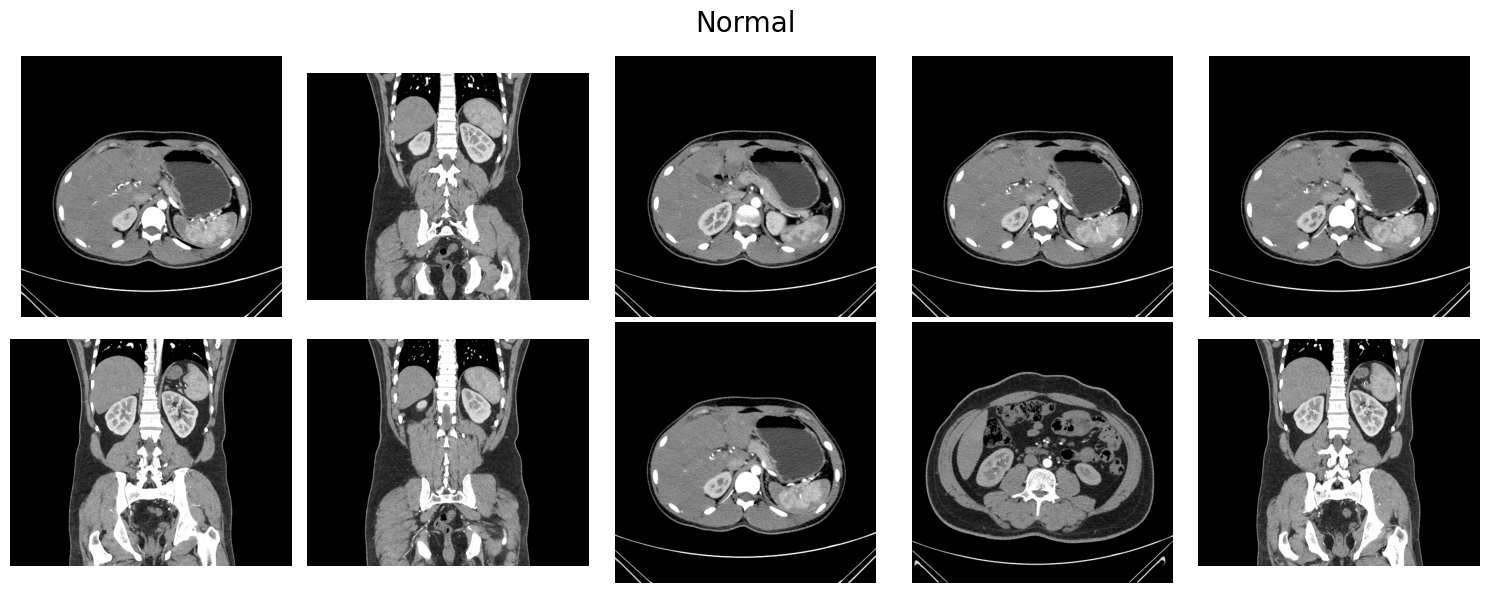

In [7]:
# Healthy Kidney
show_images(os.path.join(dataset_path+"/Normal"),"Normal")

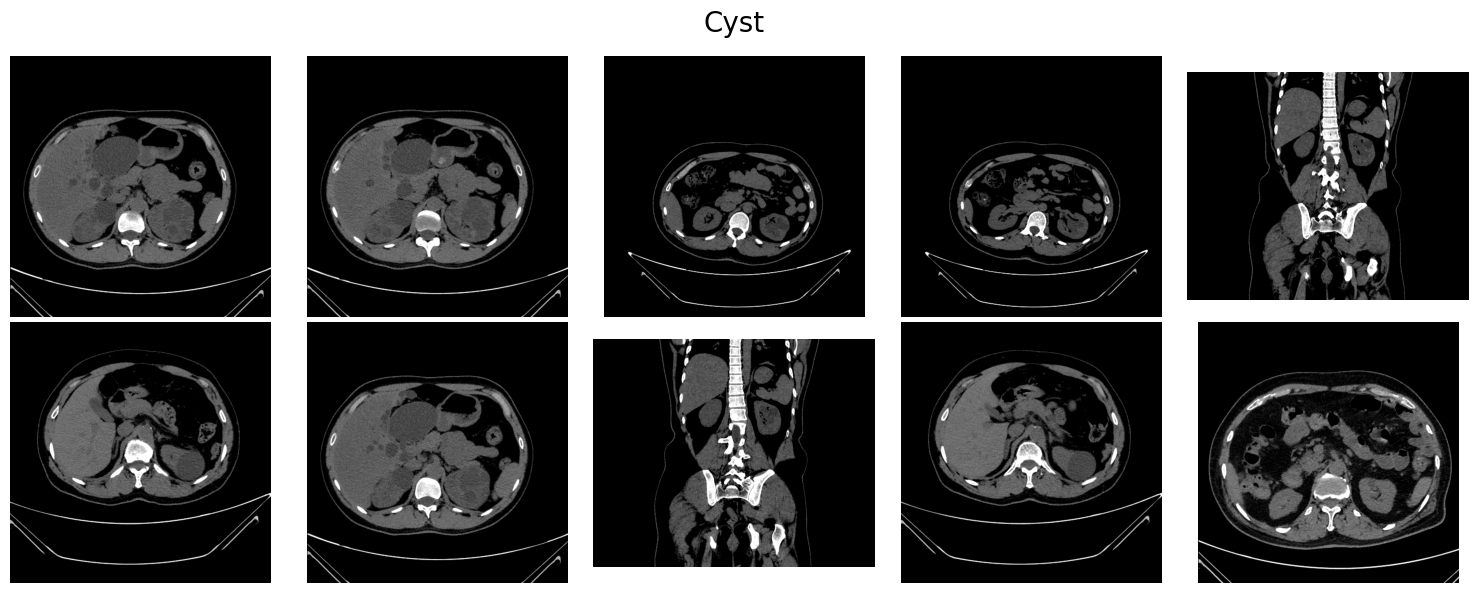

In [8]:
# Cyst
show_images(os.path.join(dataset_path+"/Cyst"),"Cyst")

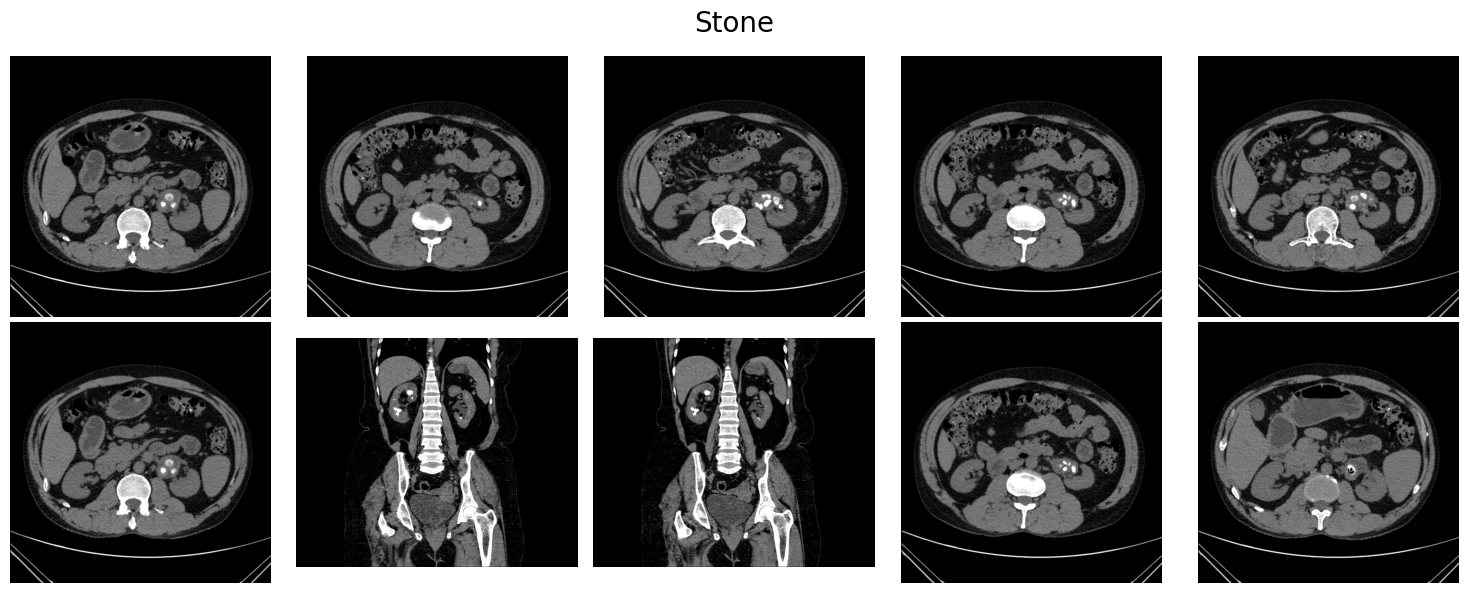

In [9]:
# Stone
show_images(os.path.join(dataset_path+"/Stone"),"Stone")


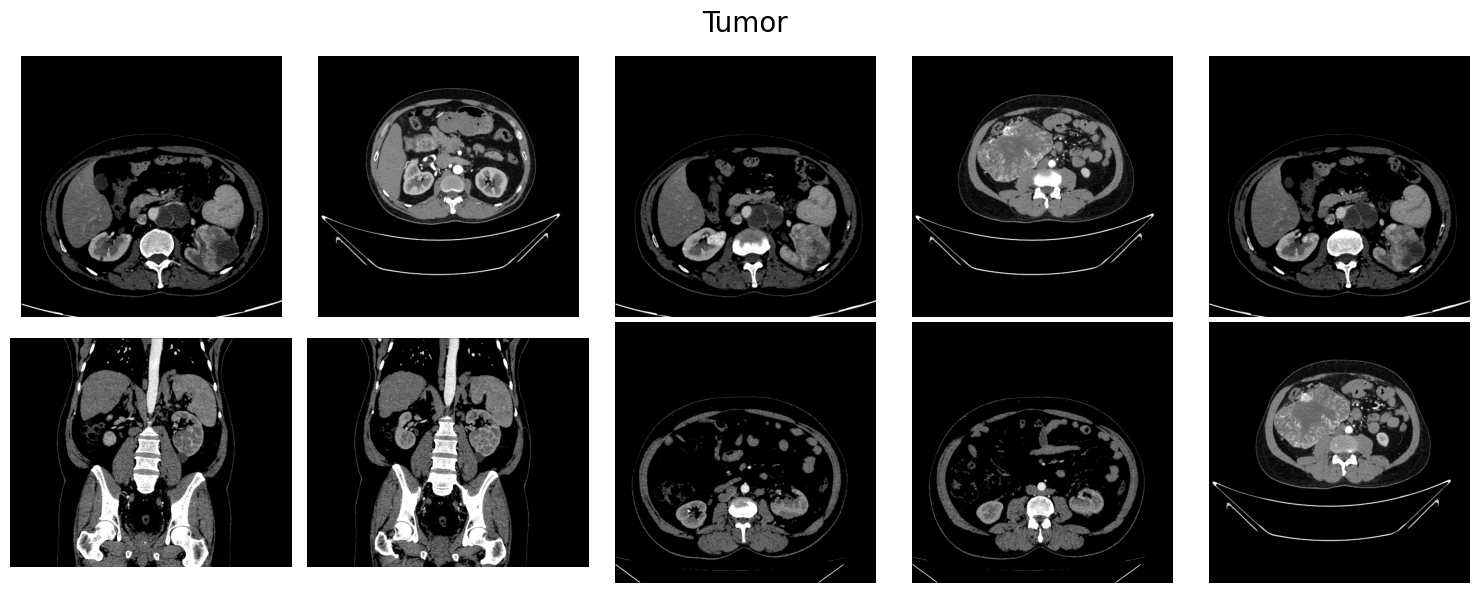

In [10]:
# Tumor
show_images(os.path.join(dataset_path+"/Tumor"),"Tumor")

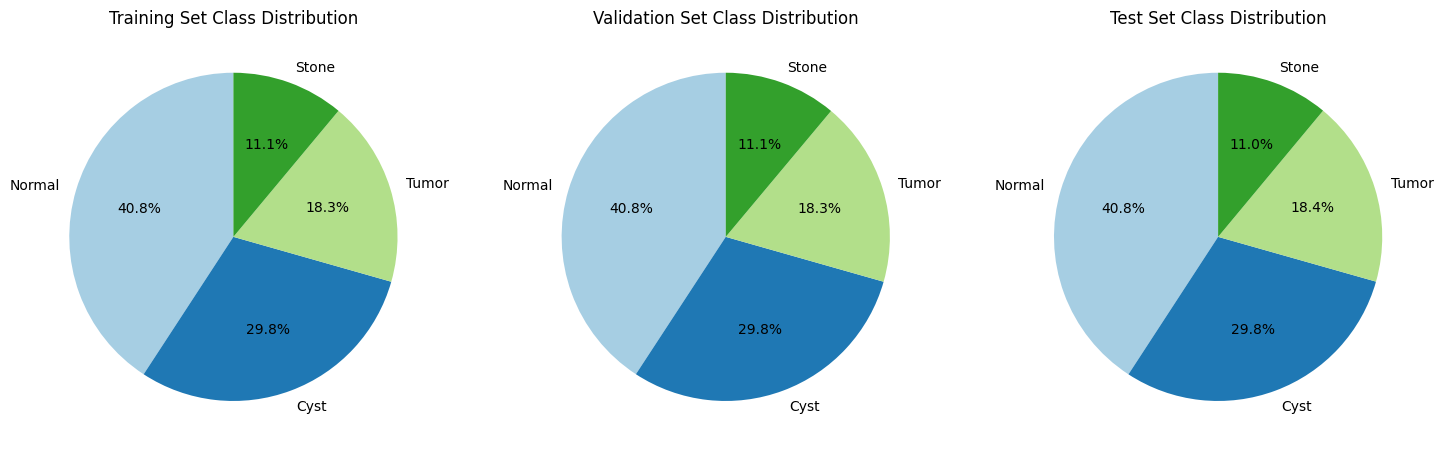

In [11]:
# === PLOT CLASS DISTRIBUTION ===
def plot_class_distribution(df, title, subplot_idx):
    class_counts = df["label"].value_counts()
    plt.subplot(1, 3, subplot_idx)
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(title)

plt.figure(figsize=(18, 6))
plot_class_distribution(train_df, "Training Set Class Distribution", 1)
plot_class_distribution(val_df, "Validation Set Class Distribution", 2)
plot_class_distribution(test_df, "Test Set Class Distribution", 3)
plt.show()

In [12]:
# === LOAD RESNET50 MODEL ===
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# === FREEZE BASE LAYERS ===
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially

# === ADD CUSTOM LAYERS ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(len(df["label"].unique()), activation="softmax")(x)  # Output layer with # of classes

# === CREATE FINAL MODEL ===
model = Model(inputs=base_model.input, outputs=x)

In [13]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_recall', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_recall', patience = 5)

In [14]:
# === COMPILE MODEL ===
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [15]:
# === TRAIN MODEL ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks = [lr_callback, stop_callback]
)

Epoch 1/12
234/234 [==============================] - 372s 2s/step - loss: 0.7279 - accuracy: 0.7269 - precision: 0.8294 - recall: 0.5953 - val_loss: 0.5112 - val_accuracy: 0.8216 - val_precision: 0.8496 - val_recall: 0.7742 - lr: 1.0000e-04
Epoch 2/12
234/234 [==============================] - 388s 2s/step - loss: 0.4001 - accuracy: 0.8590 - precision: 0.8882 - recall: 0.8250 - val_loss: 0.3676 - val_accuracy: 0.8638 - val_precision: 0.8877 - val_recall: 0.8477 - lr: 1.0000e-04
Epoch 3/12
234/234 [==============================] - 370s 2s/step - loss: 0.3060 - accuracy: 0.8923 - precision: 0.9068 - recall: 0.8726 - val_loss: 0.4520 - val_accuracy: 0.8260 - val_precision: 0.8509 - val_recall: 0.8072 - lr: 1.0000e-04
Epoch 4/12
234/234 [==============================] - 381s 2s/step - loss: 0.2521 - accuracy: 0.9105 - precision: 0.9215 - recall: 0.8934 - val_loss: 0.2863 - val_accuracy: 0.8971 - val_precision: 0.9117 - val_recall: 0.8831 - lr: 1.0000e-04
Epoch 5/12
234/234 [============

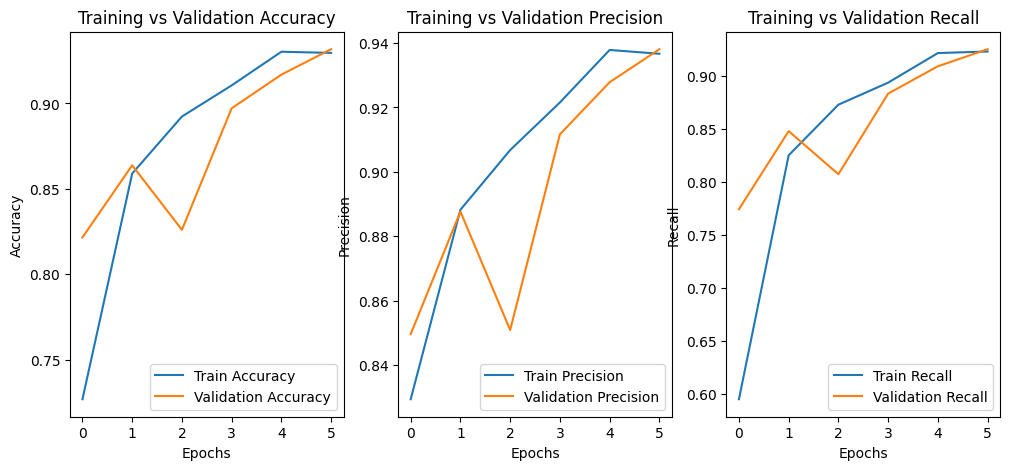

In [16]:
# === PLOT TRAINING HISTORY ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Precision plot
plt.subplot(1, 3, 2)
plt.plot(history.history["precision"], label="Train Precision")
plt.plot(history.history["val_precision"], label="Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.title("Training vs Validation Precision")

# Recall plot
plt.subplot(1, 3, 3)
plt.plot(history.history["recall"], label="Train Recall")
plt.plot(history.history["val_recall"], label="Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.title("Training vs Validation Recall")

plt.show()

In [17]:
# === EVALUATE MODEL ON TEST DATA ===
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

78/78 [==============================] - 99s 1s/step - loss: 0.1816 - accuracy: 0.9337 - precision: 0.9409 - recall: 0.9273
Test Accuracy: 0.9337
Test Precision: 0.9409
Test Recall: 0.9273


In [18]:
# === CLASSIFICATION REPORT ===
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

78/78 [==============================] - 110s 1s/step
Classification Report:
              precision    recall  f1-score   support

        Cyst       0.93      0.98      0.95       742
      Normal       0.93      0.98      0.95      1016
       Stone       0.89      0.74      0.81       275
       Tumor       0.98      0.88      0.93       457

    accuracy                           0.93      2490
   macro avg       0.93      0.89      0.91      2490
weighted avg       0.93      0.93      0.93      2490



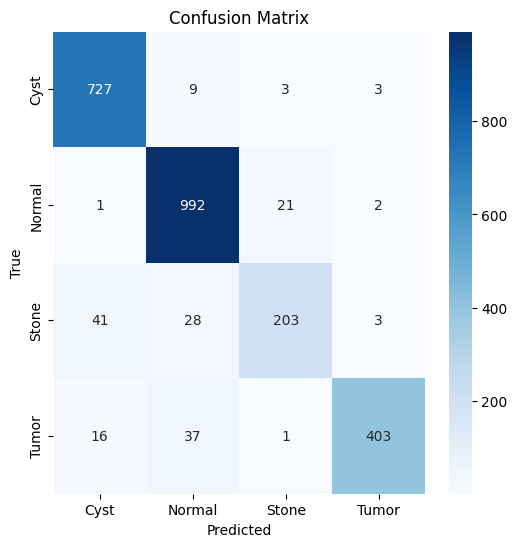

In [19]:
# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [20]:
# === SAVE MODEL ===
model.save('my_model.keras')

1/1 [==============================] - 2s 2s/step


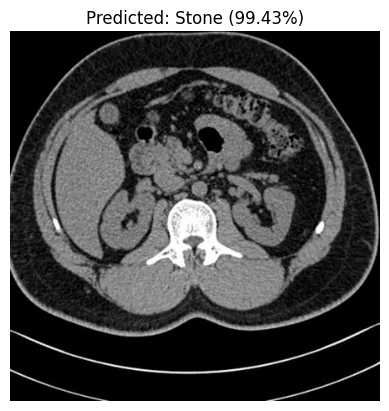

In [21]:
import os
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input


# === UPLOAD GAMBAR ===
uploaded = {"normal.jpg":"normal.jpg"}  # manually list your test image filename

# === LOAD MODEL (format .keras) ===
model = load_model("my_model.keras")  # Sesuaikan path model

# === URUTAN KELAS (sesuai saat training) ===
class_names = class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Hasilnya: ['Cyst', 'Normal', 'Stone', 'Tumor'] atau sesuai isi folder

# === PREDIKSI SETIAP GAMBAR YANG DIUPLOAD ===
for filename in uploaded.keys():
    # Baca gambar dan ubah ke ukuran ResNet50
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))  # ResNet50 input
    img_array = preprocess_input(np.expand_dims(img_resized, axis=0))

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Tampilkan hasil prediksi
    plt.imshow(img_rgb)
    confidence = np.max(prediction) * 100
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()